In [190]:
import numpy as np
import math
import random
from operator import itemgetter
from sklearn.datasets import load_iris
np.random.seed(1234)

# Data Set

In [191]:
# 1. digits

from sklearn import datasets
dataset = datasets.load_digits()
#Classification for two classes and two features
x1, y1 = dataset['data'], dataset['target']

print("\nDigits:")
print(f'x1: {x1.shape}\ny1:{y1.shape}')

#------------------------------------------------

# 2. optdigits

from sklearn import datasets
import numpy as np
from sklearn.datasets import fetch_openml
dataset = fetch_openml(name='optdigits',version=1)
#Classification for two classes and two features
x2, y2 = dataset['data'], dataset['target']
#x2 = x2.astype(int)
y2 = y2.astype(int)
print("\noptdigits:")
print(f'x2: {x2.shape}\ny2:{y2.shape}')

#------------------------------------------------

# 3. waveform-5000

from sklearn import datasets
import numpy as np
from sklearn.datasets import fetch_openml
dataset = fetch_openml(name='waveform-5000',version=1)
#Classification for two classes and two features
x3, y3 = dataset['data'], dataset['target']
#x3 = x3.astype(int)
y3 = y3.astype(int)
print("\nwaveform-5000:")
print(f'x3: {x3.shape}\ny2:{y3.shape}')


Digits:
x1: (1797, 64)
y1:(1797,)

optdigits:
x2: (5620, 64)
y2:(5620,)

waveform-5000:
x3: (5000, 40)
y2:(5000,)


# 1 Softmax Regression

In [192]:
def one_hot_coding(y):

        #Number of different labels
        num_classes = np.max(y)+1
        #Number of data points
        num_instances = y.shape[0]

        indicator = np.zeros([num_instances,num_classes])

        for i in range(num_instances):

            label = y[i]
            #print(label)
            indicator[i,label] = 1

        return indicator 

## 1.1 Optimizer

In [193]:
class Moment_Grad2:
    
    def __init__(
        self,
        learning_rate=0.01,
        momentum=0.9,
        max_iters=2000,
        batch_size=20,
        T=20, # if the validation accuracy doesn't change in T steps it terminates
        reg_strength=0,
        history_step=20,
    ):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.batch_size = batch_size
        self.momentum = momentum
        self.T = T
        self.history = {"tr_accuracy": [], "val_accuracy": []} 
        self.print_w = False

    #Randomly select two batchs of data with desired size
    def batch(self,x,y,size):

        #With no seed
        permute = np.random.permutation(x.shape[0])

        x = x[permute][:size]
        y = y[permute][:size]
        
        return x,y
    
    def softmax(self,X):
      
        X_exp = np.exp(X-X.max())
        partition = X_exp.sum( 1 , keepdims = True )
        return ( X_exp / partition )  # The broadcasting mechanism is applied here

  
    def gradient( self,x, y, w ):# define the gradient function
            
            yh =  x @ w #N*C
            N, D = x.shape 
            grad = (x.T@(y-yh))/N
            return grad # D*C 

    def acc(self,x,y,w):
        
        predict = self.softmax(x@w)
        predict_class = np.argmax(predict, axis=1)
        num_true = np.count_nonzero(predict_class == y)
        return num_true / y.shape[0]
        
    def run(self, gradient_fn, batch_size, x_tr, y_tr, x_val, y_val):
        
        batch_x,batch_y = self.batch(x_tr,y_tr,batch_size)
        x = x_tr
        y = y_tr

        N,D = x_tr.shape
        C = y_tr.max() + 1 # Number of classes

        indicator = one_hot_coding(batch_y)# N*C

        self.history["val_accuracy"] = []
        self.history["tr_accuracy"] = []

        #np.random.seed(23)
        w = np.zeros([D, C])
        best_w = w

        accu = -np.inf
        counter = 0
        t = 0
        
        # MOMENTUM
        momentum = self.momentum
        
        grad = self.gradient( batch_x , indicator , w )
        
        delta_w = ( 1-momentum ) * grad

        for iteration in range(self.max_iters):
          
            #Gradient
            grad = self.gradient( batch_x , indicator , w ) #D*C
            
            delta_w = momentum * delta_w - (1-momentum) * grad
            
            w = w - self.learning_rate * delta_w
            
            #Check if the validation error is decresing or not
            #Same as checking whether the validation accuracy is increasing or not
            if accu < self.acc(x_val,y_val,w):
                accu = self.acc(x_val,y_val,w)
                best_w = w
            else:
                counter+=1
            t=t+1

            acc_tr = self.acc(x_tr,y_tr,w)

            #Track the training and validation accuracy in each iteration
            self.history["val_accuracy"].append(accu)
            self.history["tr_accuracy"].append(acc_tr)
                
            if counter > self.T:
                break
        
        #Print the result
        if self.print_w :
          print(best_w)
          print(f'Accuracy for the validation set with optimal w: {accu}')
          print(f'Number of iterations: {t}')
        
        return best_w#D*C

## 1.2 Model

In [194]:
class SoftmaxRegression2:
    
    def __init__(self, add_bias=True):
        self.add_bias = add_bias 
        
    #From a 1d-array of labels to an indicator matrix, 
    #where each row of the matrix is made of a one-hot vector
    #We assume that each label in y is represented by a non-negative integer
    def one_hot_coding(self,y):

        #Number of different labels
        num_classes = np.max(y)+1
        #Number of data points
        num_instances = y.shape[0]

        indicator = np.zeros([num_instances,num_classes],dtype=np.float128)

        for i in range(num_instances):

            label = y[i]
            #print(label)
            indicator[i,label] = 1

        return indicator 
    
    # x: N x D
    # y: N x 1
    #model.fit(x_train , y_train ,temp_batch_size, temp_optimizer)
    def fit(self, x,  y, batch_size, optimizer):
        
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        
        val_size = x.shape[0]//10
        x_tr = x[val_size:]; y_tr = y[val_size:]
        x_val = x[:val_size]; y_val = y[:val_size]
        
        if x.ndim == 1:
            x = x[:,None]
        
        def gradient( x, y, w ):# define the gradient function
            
            yh =  x @ w #N*C
            N, D = x.shape 
            grad = (x.T@(y-yh))/N
            return grad # D*C

        w = optimizer.run(gradient, batch_size, x_tr, y_tr, x_val, y_val)
        
        self.w = w
        return self
    
    def softmax(self,X):
      
      X_exp = np.exp(X-X.max())

      if X.ndim == 1:
        partition = X_exp.sum()
      else:
        partition = X_exp.sum( 1 , keepdims = True )
       
      return (X_exp / partition)  # The broadcasting mechanism is applied here

    #Cost function: gives back the mean cost (i.e. cost per data point)
    def softmax_cost(self,x_test,y_test):
        N,D = x_test.shape
        if self.add_bias:
            x = np.column_stack( [x_test,np.ones(N)])
        z = x@self.w      # N*C : prediction for the indicator matrix
        indicator = self.one_hot_coding(y_test) # N*C
        t = 0
        for i in range(N):
            t += np.dot(indicator[i],z[i]) - np.log1p(np.exp(z[i]).sum()) 
        return -t/N #Return the mean cost

    #Accuracy: Gives back the accuracy (in decimal format) of the model fitting
    def accuracy(self,x_test,y_test):

        predict = self.predict(x_test) #N*C
        if predict.ndim ==1:
            predict_class = np.argmax(predict)
        else:
            predict_class = np.argmax(predict, axis=1)
        num_true = np.count_nonzero(predict_class == y_test)
        return num_true / y_test.shape[0]


    # Gives back a N*C matrix, with ij-th element being the probability of i-th
    # data being classied as label j
    def predict(self, x):

        N = x.shape[0]

        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
                
        yh = x@self.w # yh: N*C
        
        yh = self.softmax(yh)
         
        return yh

## Model and optimizer with usual termination condition

In [195]:
class Moment_Grad:
    
    #Commonlly the hyper-parameter momentun beta is > 0.9
    def __init__(self, learning_rate=.001, momentum = 0.9, max_iters=1e4, epsilon=1e-8, record_history=False):
        
        #Hyper_parameters
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        #Termination conditions
        self.max_iters = max_iters
        self.epsilon = epsilon
        
        #History record
        self.record_history = record_history
        if record_history:
            self.w_history = []                 #to store the weight history for visualization

        
    #Randomly select two batchs of data with desired size
    def batch(self,x,y,size):

        #With no seed
        permute = np.random.permutation(x.shape[0])

        #With seed
        #permute=np.random.RandomState(seed=42).permutation(x.shape[0])

        x = x[permute][:size]
        y = y[permute][:size]
        return x,y
    
    def run(self, gradient_fn, x, y, batch_size, w):
        
        batch_x,batch_y = self.batch(x,y,batch_size)
        
        t = 1 #counter
        grad = gradient_fn(batch_x, batch_y, w) #grad at T=1
        
        #The initial delta_w at T = 1
        delta_w = (1-self.momentum)*grad
        
        #Termination conditions
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            
            # w at T = t+1
            w = w - self.learning_rate * delta_w         # weight update step
            
            grad = gradient_fn(batch_x, batch_y, w)       # compute the gradient with present weight
            
            #delta_w at T = t+1
            delta_w = self.momentum*delta_w + (1-self.momentum)*grad
            
            if self.record_history:
                self.w_history.append(w)
            t += 1  
                     
        return w

In [196]:
class SoftmaxRegression:
    
    def __init__(self, add_bias=True):
        self.add_bias = add_bias 
        
    #From a 1d-array of labels to an indicator matrix, 
    #where each row of the matrix is made of a one-hot vector
    #We assume that each label in y is represented by a non-negative integer
    def one_hot_coding(self,y):

        #Number of different labels
        num_classes = np.max(y)+1
        #Number of data points
        num_instances = y.shape[0]

        indicator = np.zeros([num_instances,num_classes])

        for i in range(num_instances):

            label = y[i]
            #print(label)
            indicator[i,label] = 1

        return indicator 
    
    # x: N x D
    # y: N x 1
    def fit(self, x,  y, batch_size, optimizer):
        
        if x.ndim == 1:
            x = x[:, None]
            
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        
        # N: num of instances
        # D: num of features
        N,D = x.shape
        num_classes = np.max(y)+1
        
        # indicator: N * C
        indicator_matrix = self.one_hot_coding( y )
        C = indicator_matrix.shape[1]
        
        def gradient(x, y, w):                          # define the gradient function
            yh = (x @ w)
            N, D = x.shape
            grad = np.dot(yh-y, x)/N
            return grad
        
        w0 = np.zeros([D,C]).T                              # initialize the weights to 0  
        for i in range(C):               
            w0[i] = optimizer.run(gradient, x, indicator_matrix.T[i],batch_size, w0[i])    # run the optimizer to get the optimal weights
        
        self.w = w0.T # w: D*C
        
        return self
    
    def softmax(self,X):

      X_exp = np.exp(X-X.max())
     
      if X.ndim == 1:
        partition = X_exp.sum()
      else:
        partition = X_exp.sum( 1, keepdims = True )
       
      return X_exp / partition  # The broadcasting mechanism is applied here

    
    #Cost function: gives back the mean cost (i.e. cost per data point)
    def softmax_cost(self,x_test,y_test):
        N,D = x_test.shape
        if self.add_bias:
            x = np.column_stack([x_test,np.ones(N)])
        z = x@self.w      # N*C : prediction for the indicator matrix
        indicator = self.one_hot_coding(y_test) # N*C
        t = 0
        for i in range(N):
            t += np.dot(indicator[i],z[i]) - np.log1p(np.exp(z[i]).sum()) 
        return -t/N #Return the mean cost

    #Accuracy: Gives back the accuracy (in decimal format) of the model fitting
    def accuracy(self,x_test,y_test):

        predict = self.predict(x_test) #N*C
        if predict.ndim ==1:
          predict_class = np.argmax(predict)
        else:
           predict_class = np.argmax(predict, axis=1)
        num_true = np.count_nonzero(predict_class == y_test)
        return num_true / y_test.shape[0]


    # Gives back a N*C matrix, with ij-th element being the probability of i-th
    # data being classied as label j
    def predict(self, x):

        N = x.shape[0]

        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
                
        yh = x@self.w # yh: N*C
        
        yh = self.softmax(yh)
         
        return yh

##1.3 Testing for the above model (not required):

In [197]:
from sklearn import datasets
import numpy as np
dataset = datasets.load_digits()
#Classification for two classes and two features
x, y = dataset['data'], dataset['target']
x = x3;y = y3

np.seterr(divide='ignore', invalid='ignore')

print(f'x: {x.shape}')
print(f'y: {y.shape}\n')

#Testing for the model...
total_size = 5000
train_size = 4000
test_size = total_size-train_size

x = x[:total_size]; y = y[:total_size]
x_train = x[:train_size]; x_test = x[train_size:]
y_train = y[:train_size]; y_test = y[train_size:]

print(f'Train size: {train_size}\nTest size: {test_size}\n')

model = SoftmaxRegression2()
optimizer = Moment_Grad2()

batch_size = 200
#fit(x,y , batch_size, optimizer)
model.fit(x_train , y_train ,batch_size, optimizer)

print(f'Batch size: {batch_size}\n')
#print(f'Mean cost: {model.softmax_cost(x_test,y_test)}\n') #Cost per data point
print(f'Accuracy: {model.accuracy(x_test,y_test)}')


x: (5000, 40)
y: (5000,)

Train size: 4000
Test size: 1000

Batch size: 200

Accuracy: 0.859


# 2 Required Analysis

## 2.1 Hyper_parameter of the optimization procedure

### Grid Search

#### Dataset A

In [161]:
from sklearn import datasets
import numpy as np
dataset = datasets.load_digits()
#Classification for two classes and two features
x, y = dataset['data'], dataset['target']

print(f'x: {x.shape}')
print(f'y: {y.shape}\n')

#Testing for the model...
total_size = x.shape[0]
train_size = x.shape[0]-x.shape[0]//10
test_size = total_size-train_size

x = x[:total_size]; y = y[:total_size]
x_train = x[:train_size]; x_test = x[train_size:]
y_train = y[:train_size]; y_test = y[train_size:]

print(f'Train size: {train_size}\nTest size: {test_size}\n')

batch_size = [50,60,70,80,90,100,110,120]
learning_rate = [0.001,0.002,0.003,0.004, 0.005,0.006,0.007,0.008, 0.009]
momentum = [0.9, 0.91, 0.92, 0.93, 0.94,0.95, 0.96, 0.97, 0.98, 0.99]
final_hyperparameters_a = [0,0,0,0]
temp_accuracy = 0

model = SoftmaxRegression()
for i in range(5):
  for j in range(5):
    for k in range(5):
      temp_optimizer = Moment_Grad(learning_rate[j],momentum[k])
      temp_batch_size = batch_size[i]
      model.fit(x_train , y_train ,temp_batch_size, temp_optimizer)
      model.accuracy(x_test,y_test)
      # print(f'learning_rate: {learning_rate[j]}')
      # print(f'momentum: {momentum[k]}')
      # print(f'Batch size: {temp_batch_size}')
      # print(f'Accuracy: {model.accuracy(x_test,y_test)}')
      if model.accuracy(x_test,y_test) > temp_accuracy:
        final_hyperparameters_a[0] = temp_batch_size
        final_hyperparameters_a[1] = learning_rate[j]
        final_hyperparameters_a[2] = momentum[k]
        final_hyperparameters_a[3] = model.accuracy(x_test,y_test)
        temp_accuracy = model.accuracy(x_test,y_test)

print(final_hyperparameters_a)

x: (1797, 64)
y: (1797,)

Train size: 1618
Test size: 179

[90, 0.003, 0.92, 0.8044692737430168]


#### Dataset B

In [162]:
from sklearn import datasets
import numpy as np
from sklearn.datasets import fetch_openml
dataset = fetch_openml(name='optdigits',version=1)
#Classification for two classes and two features
x, y = dataset['data'], dataset['target']
#x3 = x3.astype(int)
y = y.astype(int)

print(f'x: {x.shape}')
print(f'y: {y.shape}\n')

#Testing for the model...
total_size = x.shape[0]
train_size = x.shape[0]-x.shape[0]//10
test_size = total_size-train_size

x = x[:total_size]; y = y[:total_size]
x_train = x[:train_size]; x_test = x[train_size:]
y_train = y[:train_size]; y_test = y[train_size:]

print(f'Train size: {train_size}\nTest size: {test_size}\n')

batch_size = [50,60,70,80,90,100,110,120]
learning_rate = [0.001,0.002,0.003,0.004, 0.005,0.006,0.007,0.008, 0.009]
momentum = [0.9, 0.91, 0.92, 0.93, 0.94,0.95, 0.96, 0.97, 0.98, 0.99]
final_hyperparameters_b = [0,0,0,0]
temp_accuracy = 0

model = SoftmaxRegression()
for i in range(5):
  for j in range(5):
    for k in range(5):
      temp_optimizer = Moment_Grad(learning_rate[j],momentum[k])
      temp_batch_size = batch_size[i]
      model.fit(x_train , y_train ,temp_batch_size, temp_optimizer)
      model.accuracy(x_test,y_test)
      # print(f'learning_rate: {learning_rate[j]}')
      # print(f'momentum: {momentum[k]}')
      # print(f'Batch size: {temp_batch_size}')
      # print(f'Accuracy: {model.accuracy(x_test,y_test)}')
      if model.accuracy(x_test,y_test) > temp_accuracy:
        final_hyperparameters_b[0] = temp_batch_size
        final_hyperparameters_b[1] = learning_rate[j]
        final_hyperparameters_b[2] = momentum[k]
        final_hyperparameters_b[3] = model.accuracy(x_test,y_test)
        temp_accuracy = model.accuracy(x_test,y_test)

print(final_hyperparameters_b)

x: (5620, 64)
y: (5620,)

Train size: 5058
Test size: 562

[90, 0.002, 0.92, 0.7935943060498221]


#### Dataset C

In [163]:
from sklearn import datasets
import numpy as np
from sklearn.datasets import fetch_openml
dataset = fetch_openml(name='waveform-5000',version=1)
#Classification for two classes and two features
x, y = dataset['data'], dataset['target']
#x3 = x3.astype(int)
y = y.astype(int)

print(f'x: {x.shape}')
print(f'y: {y.shape}\n')

#Testing for the model...
total_size = x.shape[0]
train_size = x.shape[0]-x.shape[0]//10
test_size = total_size-train_size

x = x[:total_size]; y = y[:total_size]
x_train = x[:train_size]; x_test = x[train_size:]
y_train = y[:train_size]; y_test = y[train_size:]

print(f'Train size: {train_size}\nTest size: {test_size}\n')

batch_size = [50,60,70,80,90,100,110,120]
learning_rate = [0.001,0.002,0.003,0.004, 0.005,0.006,0.007,0.008, 0.009]
momentum = [0.9, 0.91, 0.92, 0.93, 0.94,0.95, 0.96, 0.97, 0.98, 0.99]
final_hyperparameters_b = [0,0,0,0]
temp_accuracy = 0

model = SoftmaxRegression()
for i in range(5):
  for j in range(5):
    for k in range(5):
      temp_optimizer = Moment_Grad(learning_rate[j],momentum[k])
      temp_batch_size = batch_size[i]
      model.fit(x_train , y_train ,temp_batch_size, temp_optimizer)
      model.accuracy(x_test,y_test)
      # print(f'learning_rate: {learning_rate[j]}')
      # print(f'momentum: {momentum[k]}')
      # print(f'Batch size: {temp_batch_size}')
      # print(f'Accuracy: {model.accuracy(x_test,y_test)}')
      if model.accuracy(x_test,y_test) > temp_accuracy:
        final_hyperparameters_b[0] = temp_batch_size
        final_hyperparameters_b[1] = learning_rate[j]
        final_hyperparameters_b[2] = momentum[k]
        final_hyperparameters_b[3] = model.accuracy(x_test,y_test)
        temp_accuracy = model.accuracy(x_test,y_test)

print(final_hyperparameters_b)

x: (5000, 40)
y: (5000,)

Train size: 4500
Test size: 500

[80, 0.004, 0.94, 0.694]


## Cross Validation

### Dataset A

In [164]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt 
import datetime
dataset = datasets.load_digits()
#Classification for two classes and two features
x_rest, y_rest = dataset['data'], dataset['target']

In [165]:
def cross_validate(n, n_folds=5):
  n_val = n // n_folds
  for f in range(n_folds):
    tr_inds = []
    val_inds = list(range(f * n_val, (f+1)*n_val))
    if f > 0:
      tr_inds = list(range(f*n_val))
    if f < n_folds - 1:
      tr_inds = tr_inds + list(range((f+1)*n_val, n))
    yield tr_inds, val_inds

#### Batch Size

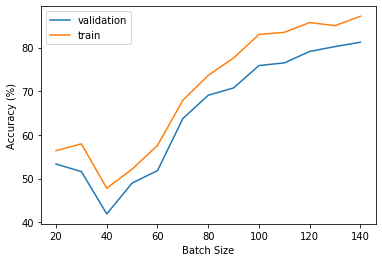

In [166]:
n_rest = len(x_rest)
K_list = range(20,150,10)
num_folds = 5
time_list = []
err_valid, err_train = np.zeros((len(K_list), num_folds)), np.zeros((len(K_list), num_folds))
for i, K in enumerate(K_list):
  for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
    begin_time = datetime.datetime.now()
    model = SoftmaxRegression()
    temp_optimizer = Moment_Grad(final_hyperparameters_a[1],final_hyperparameters_a[2])
    tempx = []
    tempy = []
    tempx_val = []
    tempy_val = []
    for j in range(len(tr)):
      tempx.append(x_rest[tr[j]])
      tempy.append(y_rest[tr[j]])
    tempx = np.array(tempx)
    tempy = np.array(tempy)
    model.fit(tempx, tempy, K, temp_optimizer)
    err_train[i, f] = 100 * model.accuracy(tempx,tempy)
    for k in range(len(val)):
      tempx_val.append(x_rest[val[k]])
      tempy_val.append(y_rest[val[k]])
    tempx_val = np.array(tempx_val)
    tempy_val = np.array(tempy_val)
    err_valid[i, f] = 100 * model.accuracy(tempx_val,tempy_val)
  model = SoftmaxRegression()
  temp_optimizer = Moment_Grad(final_hyperparameters_a[1],final_hyperparameters_a[2])
  model.fit(x_rest, y_rest,K ,temp_optimizer)
  time_list.append((datetime.datetime.now() - begin_time).total_seconds())

plt.plot(K_list, np.mean(err_valid, axis=1),  label='validation')
plt.plot(K_list, np.mean(err_train, axis=1),  label='train')
plt.legend()
plt.xlabel('Batch Size')
plt.ylabel('Accuracy (%)')
plt.show()

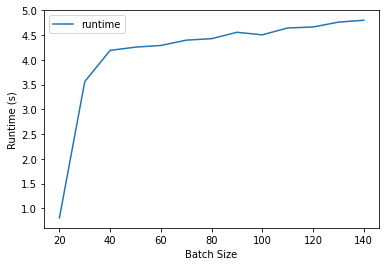

In [167]:
plt.plot(K_list, time_list,  label='runtime')
plt.legend()
plt.xlabel('Batch Size')
plt.ylabel('Runtime (s)')
plt.show()

#### Learning Rate

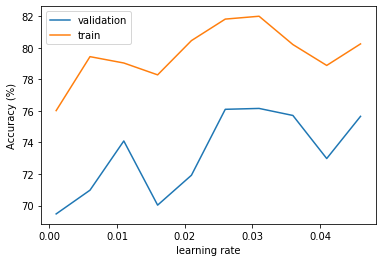

In [168]:
n_rest = len(x_rest)
learning_rate = [x / 1000.0 for x in range(1, 50, 5)]
num_folds = 5
time_list = []
err_valid, err_train = np.zeros((len(learning_rate), num_folds)), np.zeros((len(learning_rate), num_folds))
for i, K in enumerate(learning_rate):
  for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
    begin_time = datetime.datetime.now()
    model = SoftmaxRegression()
    temp_optimizer = Moment_Grad(learning_rate[int(K)],final_hyperparameters_a[2])
    tempx = []
    tempy = []
    tempx_val = []
    tempy_val = []
    for j in range(len(tr)):
      tempx.append(x_rest[tr[j]])
      tempy.append(y_rest[tr[j]])
    tempx = np.array(tempx)
    tempy = np.array(tempy)
    model.fit(tempx, tempy, final_hyperparameters_a[0], temp_optimizer)
    err_train[i, f] = 100 * model.accuracy(tempx,tempy)
    for k in range(len(val)):
      tempx_val.append(x_rest[val[k]])
      tempy_val.append(y_rest[val[k]])
    tempx_val = np.array(tempx_val)
    tempy_val = np.array(tempy_val)
    err_valid[i, f] = 100 * model.accuracy(tempx_val,tempy_val)
  model = SoftmaxRegression()
  temp_optimizer = Moment_Grad(learning_rate[int(K)],final_hyperparameters_a[2])
  model.fit(x_rest, y_rest, final_hyperparameters_a[0], temp_optimizer)
  time_list.append((datetime.datetime.now() - begin_time).total_seconds())

plt.plot(learning_rate, np.mean(err_valid, axis=1),  label='validation')
plt.plot(learning_rate, np.mean(err_train, axis=1),  label='train')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('Accuracy (%)')
plt.show()

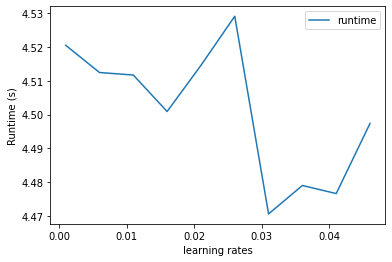

In [169]:
plt.plot(learning_rate, time_list,  label='runtime')
plt.legend()
plt.xlabel('learning rates')
plt.ylabel('Runtime (s)')
plt.show()

#### Momentum

In [170]:
dataset = datasets.load_digits()
#Classification for two classes and two features
x_rest, y_rest = dataset['data'], dataset['target']

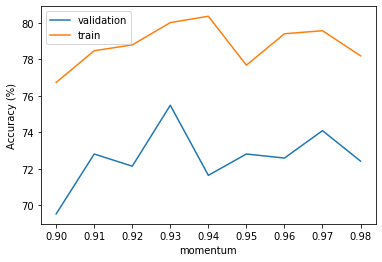

In [171]:
n_rest = len(x_rest)
momentum = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98]
num_folds = 5
err_valid, err_train = np.zeros((len(momentum), num_folds)), np.zeros((len(momentum), num_folds))
time_list = []
for i, K in enumerate(momentum):
  for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
    begin_time = datetime.datetime.now()
    model = SoftmaxRegression()
    temp_optimizer = Moment_Grad(final_hyperparameters_a[1],momentum[int(K)])
    tempx = []
    tempy = []
    tempx_val = []
    tempy_val = []
    for j in range(len(tr)):
      tempx.append(x_rest[tr[j]])
      tempy.append(y_rest[tr[j]])
    tempx = np.array(tempx)
    tempy = np.array(tempy)
    model.fit(tempx, tempy,final_hyperparameters_a[0], temp_optimizer)
    err_train[i, f] = 100 * model.accuracy(tempx,tempy)
    for k in range(len(val)):
      tempx_val.append(x_rest[val[k]])
      tempy_val.append(y_rest[val[k]])
    tempx_val = np.array(tempx_val)
    tempy_val = np.array(tempy_val)
    err_valid[i, f] = 100 * model.accuracy(tempx_val,tempy_val)
  model = SoftmaxRegression()
  temp_optimizer = Moment_Grad(final_hyperparameters_a[1],momentum[int(K)])
  model.fit(x_rest, y_rest,final_hyperparameters_a[0] ,temp_optimizer)
  time_list.append((datetime.datetime.now() - begin_time).total_seconds())

plt.plot(momentum, np.mean(err_valid, axis=1),  label='validation')
plt.plot(momentum, np.mean(err_train, axis=1),  label='train')
plt.legend()
plt.xlabel('momentum')
plt.ylabel('Accuracy (%)')
plt.show()

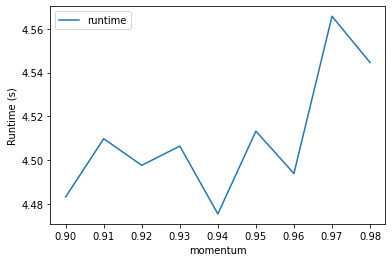

In [172]:
plt.plot(momentum, time_list,  label='runtime')
plt.legend()
plt.xlabel('momentum')
plt.ylabel('Runtime (s)')
plt.show()

### Dataset B

In [173]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt 
import datetime
from sklearn.datasets import fetch_openml
dataset = fetch_openml(name='optdigits',version=1)
#Classification for two classes and two features
x_rest_b, y_rest_b = dataset['data'], dataset['target']
#x3 = x3.astype(int)
y_rest_b = y_rest_b.astype(int)

#### Batch Size

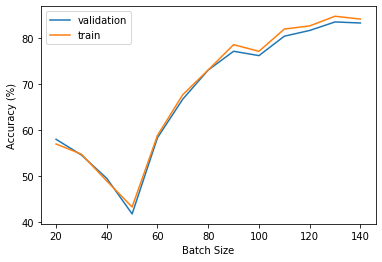

In [174]:
n_rest = len(x_rest_b)
K_list = range(20,150,10)
num_folds = 5
time_list = []
err_valid, err_train = np.zeros((len(K_list), num_folds)), np.zeros((len(K_list), num_folds))
for i, K in enumerate(K_list):
  for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
    begin_time = datetime.datetime.now()
    model = SoftmaxRegression()
    temp_optimizer = Moment_Grad(final_hyperparameters_b[1],final_hyperparameters_b[2])
    tempx = []
    tempy = []
    tempx_val = []
    tempy_val = []
    for j in range(len(tr)):
      tempx.append(x_rest_b[tr[j]])
      tempy.append(y_rest_b[tr[j]])
    tempx = np.array(tempx)
    tempy = np.array(tempy)
    model.fit(tempx, tempy, K, temp_optimizer)
    err_train[i, f] = 100 * model.accuracy(tempx,tempy)
    for k in range(len(val)):
      tempx_val.append(x_rest_b[val[k]])
      tempy_val.append(y_rest_b[val[k]])
    tempx_val = np.array(tempx_val)
    tempy_val = np.array(tempy_val)
    err_valid[i, f] = 100 * model.accuracy(tempx_val,tempy_val)
  model = SoftmaxRegression()
  temp_optimizer = Moment_Grad(final_hyperparameters_b[1],final_hyperparameters_b[2])
  model.fit(x_rest_b, y_rest_b,K ,temp_optimizer)
  time_list.append((datetime.datetime.now() - begin_time).total_seconds())

plt.plot(K_list, np.mean(err_valid, axis=1),  label='validation')
plt.plot(K_list, np.mean(err_train, axis=1),  label='train')
plt.legend()
plt.xlabel('Batch Size')
plt.ylabel('Accuracy (%)')
plt.show()

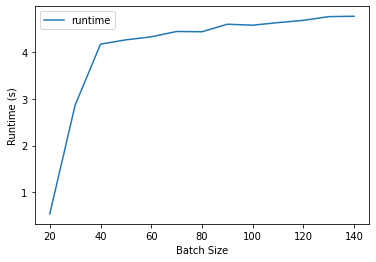

In [175]:
plt.plot(K_list, time_list,  label='runtime')
plt.legend()
plt.xlabel('Batch Size')
plt.ylabel('Runtime (s)')
plt.show()

#### Learning Rate

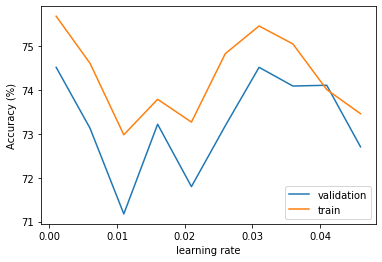

In [176]:
n_rest = len(x_rest_b)
learning_rate = [x / 1000.0 for x in range(1, 50, 5)]
num_folds = 5
time_list = []
err_valid, err_train = np.zeros((len(learning_rate), num_folds)), np.zeros((len(learning_rate), num_folds))
for i, K in enumerate(learning_rate):
  for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
    begin_time = datetime.datetime.now()
    model = SoftmaxRegression()
    temp_optimizer = Moment_Grad(learning_rate[int(K)],final_hyperparameters_b[2])
    tempx = []
    tempy = []
    tempx_val = []
    tempy_val = []
    for j in range(len(tr)):
      tempx.append(x_rest_b[tr[j]])
      tempy.append(y_rest_b[tr[j]])
    tempx = np.array(tempx)
    tempy = np.array(tempy)
    model.fit(tempx, tempy, final_hyperparameters_b[0], temp_optimizer)
    err_train[i, f] = 100 * model.accuracy(tempx,tempy)
    for k in range(len(val)):
      tempx_val.append(x_rest_b[val[k]])
      tempy_val.append(y_rest_b[val[k]])
    tempx_val = np.array(tempx_val)
    tempy_val = np.array(tempy_val)
    err_valid[i, f] = 100 * model.accuracy(tempx_val,tempy_val)
  model = SoftmaxRegression()
  temp_optimizer = Moment_Grad(learning_rate[int(K)],final_hyperparameters_b[2])
  model.fit(x_rest_b, y_rest_b, final_hyperparameters_b[0], temp_optimizer)
  time_list.append((datetime.datetime.now() - begin_time).total_seconds())

plt.plot(learning_rate, np.mean(err_valid, axis=1),  label='validation')
plt.plot(learning_rate, np.mean(err_train, axis=1),  label='train')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('Accuracy (%)')
plt.show()

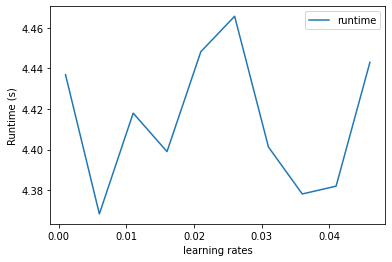

In [177]:
plt.plot(learning_rate, time_list,  label='runtime')
plt.legend()
plt.xlabel('learning rates')
plt.ylabel('Runtime (s)')
plt.show()

#### Momentum

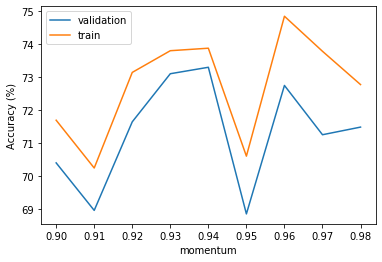

In [178]:
n_rest = len(x_rest_b)
momentum = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98]
num_folds = 5
err_valid, err_train = np.zeros((len(momentum), num_folds)), np.zeros((len(momentum), num_folds))
time_list = []
for i, K in enumerate(momentum):
  for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
    begin_time = datetime.datetime.now()
    model = SoftmaxRegression()
    temp_optimizer = Moment_Grad(final_hyperparameters_b[1],momentum[int(K)])
    tempx = []
    tempy = []
    tempx_val = []
    tempy_val = []
    for j in range(len(tr)):
      tempx.append(x_rest_b[tr[j]])
      tempy.append(y_rest_b[tr[j]])
    tempx = np.array(tempx)
    tempy = np.array(tempy)
    model.fit(tempx, tempy,final_hyperparameters_b[0], temp_optimizer)
    err_train[i, f] = 100 * model.accuracy(tempx,tempy)
    for k in range(len(val)):
      tempx_val.append(x_rest_b[val[k]])
      tempy_val.append(y_rest_b[val[k]])
    tempx_val = np.array(tempx_val)
    tempy_val = np.array(tempy_val)
    err_valid[i, f] = 100 * model.accuracy(tempx_val,tempy_val)
  model = SoftmaxRegression()
  temp_optimizer = Moment_Grad(final_hyperparameters_b[1],momentum[int(K)])
  model.fit(x_rest_b, y_rest_b,final_hyperparameters_b[0] ,temp_optimizer)
  time_list.append((datetime.datetime.now() - begin_time).total_seconds())

plt.plot(momentum, np.mean(err_valid, axis=1),  label='validation')
plt.plot(momentum, np.mean(err_train, axis=1),  label='train')
plt.legend()
plt.xlabel('momentum')
plt.ylabel('Accuracy (%)')
plt.show()

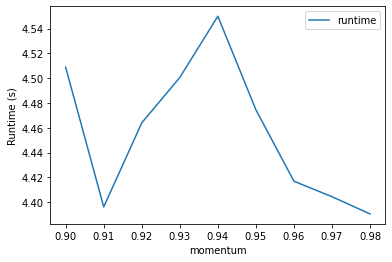

In [179]:
plt.plot(momentum, time_list,  label='runtime')
plt.legend()
plt.xlabel('momentum')
plt.ylabel('Runtime (s)')
plt.show()

## 2.2 Termination Condidtion

In [180]:
def one_hot_coding(y):

        #Number of different labels
        num_classes = np.max(y)+1
        #Number of data points
        num_instances = y.shape[0]

        indicator = np.zeros([num_instances,num_classes])

        for i in range(num_instances):

            label = y[i]
            #print(label)
            indicator[i,label] = 1

        return indicator 

In [181]:
class SoftmaxGradientDescent2:
    
    def __init__(
        self,
        learning_rate=0.01,
        max_iters=2000,
        batch_size=20,
        momentum=0.9,
        T=20, # if the validation accuracy doesn't change in T steps it terminates
        reg_strength=0,
        history_step=20,
    ):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.batch_size = batch_size
        self.momentum = momentum
        self.T = T
        self.history = {"tr_accuracy": [], "val_accuracy": []} 
        self.print_w = False

    #Randomly select two batchs of data with desired size
    def batch(self,x,y,size):

        #With no seed
        permute = np.random.permutation(x.shape[0])

        x = x[permute][:size]
        y = y[permute][:size]
        
        return x,y
    
    def softmax(self,X):
      
        X_exp = np.exp(X-X.max())
        partition = X_exp.sum( 1 , keepdims = True )
        return ( X_exp / partition )  # The broadcasting mechanism is applied here

  
    def gradient( self,x, y, w ):# define the gradient function
            
            yh =  x @ w #N*C
            N, D = x.shape 
            grad = (x.T@(y-yh))/N
            return grad # D*C 

    def acc(self,x,y,w):
        
        predict = self.softmax(x@w)
        predict_class = np.argmax(predict, axis=1)
        num_true = np.count_nonzero(predict_class == y)
        return num_true / y.shape[0]
        
    def run(self, gradient_fn, batch_size, x_tr, y_tr, x_val, y_val):
        
        batch_x,batch_y = self.batch(x_tr,y_tr,batch_size)
        x = x_tr
        y = y_tr

        N,D = x_tr.shape
        C = y_tr.max() + 1 # Number of classes

        indicator = one_hot_coding(batch_y)# N*C

        self.history["val_accuracy"] = []
        self.history["tr_accuracy"] = []

        #np.random.seed(23)
        w = np.zeros([D, C])
        best_w = w

        accu = -np.inf
        counter = 0
        t = 0
        
        # MOMENTUM
        momentum = self.momentum
        
        grad = self.gradient( batch_x , indicator , w )
        
        delta_w = ( 1-momentum ) * grad

        for iteration in range(self.max_iters):
          
            #Gradient
            grad = self.gradient( batch_x , indicator , w ) #D*C
            
            delta_w = momentum * delta_w - (1-momentum) * grad
            
            w = w - self.learning_rate * delta_w
            
            #Check if the validation error is decresing or not
            #Same as checking whether the validation accuracy is increasing or not
            if accu < self.acc(x_val,y_val,w):
                accu = self.acc(x_val,y_val,w)
                best_w = w
            else:
                counter+=1
            t=t+1

            acc_tr = self.acc(x_tr,y_tr,w)

            #Track the training and validation accuracy in each iteration
            self.history["val_accuracy"].append(accu)
            self.history["tr_accuracy"].append(acc_tr)
                
            if counter > self.T:
                break
        
        print(f'Accuracy for the validation set with optimal w: {accu}')
        print(f'Number of iterations: {t}')

        if self.print_w :
          print(best_w)
        
        return best_w#D*C

In [182]:
class SoftmaxRegression2:
    
    def __init__(self, add_bias=True):
        self.add_bias = add_bias 
        
    #From a 1d-array of labels to an indicator matrix, 
    #where each row of the matrix is made of a one-hot vector
    #We assume that each label in y is represented by a non-negative integer
    def one_hot_coding(self,y):

        #Number of different labels
        num_classes = np.max(y)+1
        #Number of data points
        num_instances = y.shape[0]

        indicator = np.zeros([num_instances,num_classes],dtype=np.float128)

        for i in range(num_instances):

            label = y[i]
            #print(label)
            indicator[i,label] = 1

        return indicator 
    
    # x: N x D
    # y: N x 1
    def fit(self, x,  y, batch_size, optimizer):
        
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        
        val_size = x.shape[0]//10
        x_tr = x[val_size:]; y_tr = y[val_size:]
        x_val = x[:val_size]; y_val = y[:val_size]
        
        if x.ndim == 1:
            x = x[:,None]
        
        def gradient( x, y, w ):# define the gradient function
            
            yh =  x @ w #N*C
            N, D = x.shape 
            grad = (x.T@(y-yh))/N
            return grad # D*C

        w = optimizer.run(gradient, batch_size, x_tr, y_tr, x_val, y_val)
        
        self.w = w
        return self
    
    def softmax(self,X):
      
      X_exp = np.exp(X-X.max())

      if X.ndim == 1:
        partition = X_exp.sum()
      else:
        partition = X_exp.sum( 1 , keepdims = True )
       
      return (X_exp / partition)  # The broadcasting mechanism is applied here

    #Cost function: gives back the mean cost (i.e. cost per data point)
    def softmax_cost(self,x_test,y_test):
        N,D = x_test.shape
        if self.add_bias:
            x = np.column_stack( [x_test,np.ones(N)])
        z = x@self.w      # N*C : prediction for the indicator matrix
        indicator = self.one_hot_coding(y_test) # N*C
        t = 0
        for i in range(N):
            t += np.dot(indicator[i],z[i]) - np.log1p(np.exp(z[i]).sum()) 
        return -t/N #Return the mean cost

    #Accuracy: Gives back the accuracy (in decimal format) of the model fitting
    def accuracy(self,x_test,y_test):

        predict = self.predict(x_test) #N*C
        if predict.ndim ==1:
            predict_class = np.argmax(predict)
        else:
            predict_class = np.argmax(predict, axis=1)
        num_true = np.count_nonzero(predict_class == y_test)
        return num_true / y_test.shape[0]


    # Gives back a N*C matrix, with ij-th element being the probability of i-th
    # data being classied as label j
    def predict(self, x):

        N = x.shape[0]

        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
                
        yh = x@self.w # yh: N*C
        
        yh = self.softmax(yh)
         
        return yh

In [183]:
from sklearn import datasets
dataset = datasets.load_digits()
#Classification for two classes and two features
x, y = dataset['data'], dataset['target']

print(f'x: {x.shape}')
print(f'y: {y.shape}\n')

#Testing for the model...
total_size = x.shape[0]
train_size = x.shape[0]-x.shape[0]//5
test_size = total_size-train_size
#x = x3;y = y3

x = x[:total_size]; y = y[:total_size]
x_train = x[:train_size]; x_test = x[train_size:]
y_train = y[:train_size]; y_test = y[train_size:]

print(f'Train size: {train_size}\nTest size: {test_size}\n')

model = SoftmaxRegression2()
optimizer = SoftmaxGradientDescent2()

batch_size = 100

model.fit(x_train, y_train , batch_size, optimizer)

print(f'\nAccuracy of the final result on the testing data: {model.accuracy(x_test,y_test)}')

x: (1797, 64)
y: (1797,)

Train size: 1438
Test size: 359

Accuracy for the validation set with optimal w: 0.8461538461538461
Number of iterations: 29

Accuracy of the final result on the testing data: 0.8245125348189415


## 2.3 Comparison against another classifier

### Dataset A

In [184]:
def cross_validate(n, n_folds=5):
  n_val = n // n_folds
  for f in range(n_folds):
    tr_inds = []
    val_inds = list(range(f * n_val, (f+1)*n_val))
    if f > 0:
      tr_inds = list(range(f*n_val))
    if f < n_folds - 1:
      tr_inds = tr_inds + list(range((f+1)*n_val, n))
    yield tr_inds, val_inds

In [185]:
from sklearn import datasets
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
import datetime
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier
dataset = datasets.load_digits()
#Classification for two classes and two features
x_rest, y_rest = dataset['data'], dataset['target']

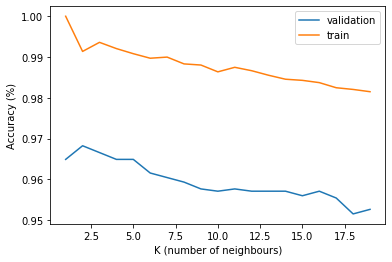

In [186]:
num_folds = 5
n_rest = len(y_rest)
K_list = range(1,20)
time_list = []
err_valid = np.zeros((len(K_list), num_folds))
err_train = np.zeros((len(K_list), num_folds))
for i, K in enumerate(K_list):
  for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
    begin_time = datetime.datetime.now()
    model = KNeighborsClassifier(n_neighbors=K)
    model = model.fit(x_rest[tr], y_rest[tr])
    y_pred = model.predict(x_rest[tr]).astype(int)
    err_train[i, f] = model.score(x_rest[tr], y_rest[tr])
    y_val_pre = model.predict(x_rest[val]).astype(np.int32)
    err_valid[i, f] = model.score(x_rest[val], y_rest[val])
  model = KNeighborsClassifier(n_neighbors=K)
  model = model.fit(x_rest, y_rest)
  time_list.append((datetime.datetime.now() - begin_time).total_seconds())

plt.plot(K_list, np.mean(err_valid, axis=1),  label='validation')
plt.plot(K_list, np.mean(err_train, axis=1),  label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('Accuracy (%)')
plt.show()

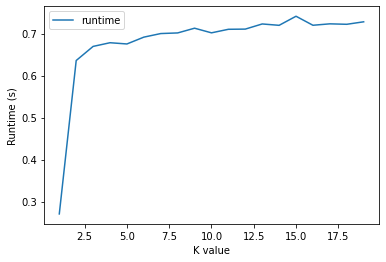

In [187]:
plt.plot(K_list, time_list,  label='runtime')
plt.legend()
plt.xlabel('K value')
plt.ylabel('Runtime (s)')
plt.show()

In [188]:
print(time_list)
print(np.mean(err_valid, axis=1))

[0.270589, 0.636008, 0.669621, 0.678389, 0.675443, 0.691703, 0.700245, 0.701724, 0.712991, 0.701954, 0.71039, 0.710833, 0.723096, 0.719844, 0.741478, 0.719999, 0.723385, 0.722302, 0.728226]
[0.96490251 0.96824513 0.96657382 0.96490251 0.96490251 0.96155989
 0.96044568 0.95933148 0.95766017 0.95710306 0.95766017 0.95710306
 0.95710306 0.95710306 0.95598886 0.95710306 0.95543175 0.95153203
 0.95264624]


### Dataset B

In [189]:
from sklearn import datasets
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
import datetime
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier
dataset = fetch_openml(name='optdigits',version=1)
#Classification for two classes and two features
x_rest, y_rest = dataset['data'], dataset['target']
#x3 = x3.astype(int)
y_rest = y_rest.astype(int)

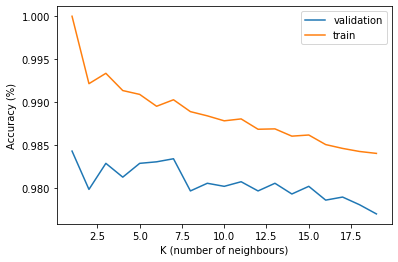

In [198]:
num_folds = 5
n_rest = len(y_rest)
K_list = range(1,20)
time_list = []
err_valid = np.zeros((len(K_list), num_folds))
err_train = np.zeros((len(K_list), num_folds))
for i, K in enumerate(K_list):
  for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
    begin_time = datetime.datetime.now()
    model = KNeighborsClassifier(n_neighbors=K)
    model = model.fit(x_rest[tr], y_rest[tr])
    y_pred = model.predict(x_rest[tr]).astype(int)
    err_train[i, f] = model.score(x_rest[tr], y_rest[tr])
    y_val_pre = model.predict(x_rest[val]).astype(np.int32)
    err_valid[i, f] = model.score(x_rest[val], y_rest[val])
  model = KNeighborsClassifier(n_neighbors=K)
  model = model.fit(x_rest, y_rest)
  time_list.append((datetime.datetime.now() - begin_time).total_seconds())

plt.plot(K_list, np.mean(err_valid, axis=1),  label='validation')
plt.plot(K_list, np.mean(err_train, axis=1),  label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('Accuracy (%)')
plt.show()

In [ ]:
plt.plot(K_list, time_list,  label='runtime')
plt.legend()
plt.xlabel('K value')
plt.ylabel('Runtime (s)')
plt.show()

In [ ]:
print(time_list)
print(np.mean(err_valid, axis=1))

### Dataset C

In [ ]:
from sklearn import datasets
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
import datetime
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier
dataset = fetch_openml(name='waveform-5000',version=1)
#Classification for two classes and two features
x_rest, y_rest = dataset['data'], dataset['target']
#x2 = x2.astype(int)
y_rest = y_rest.astype(int)

In [ ]:
num_folds = 5
n_rest = len(y_rest)
K_list = range(1,20)
time_list = []
err_valid = np.zeros((len(K_list), num_folds))
err_train = np.zeros((len(K_list), num_folds))
for i, K in enumerate(K_list):
  for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
    begin_time = datetime.datetime.now()
    model = KNeighborsClassifier(n_neighbors=K)
    model = model.fit(x_rest[tr], y_rest[tr])
    y_pred = model.predict(x_rest[tr]).astype(int)
    err_train[i, f] = model.score(x_rest[tr], y_rest[tr])
    y_val_pre = model.predict(x_rest[val]).astype(np.int32)
    err_valid[i, f] = model.score(x_rest[val], y_rest[val])
  model = KNeighborsClassifier(n_neighbors=K)
  model = model.fit(x_rest, y_rest)
  time_list.append((datetime.datetime.now() - begin_time).total_seconds())

plt.plot(K_list, np.mean(err_valid, axis=1),  label='validation')
plt.plot(K_list, np.mean(err_train, axis=1),  label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('Accuracy (%)')
plt.show()

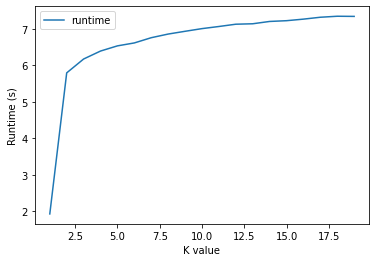

In [199]:
plt.plot(K_list, time_list,  label='runtime')
plt.legend()
plt.xlabel('K value')
plt.ylabel('Runtime (s)')
plt.show()

In [200]:
print(time_list)
print(np.mean(err_valid, axis=1))

[1.927053, 5.793949, 6.173889, 6.39213, 6.5341, 6.614601, 6.758075, 6.858061, 6.933681, 7.006965, 7.065221, 7.127785, 7.140039, 7.203506, 7.224373, 7.267125, 7.31886, 7.346357, 7.342234]
[0.98434164 0.97989324 0.98291815 0.98131673 0.98291815 0.98309609
 0.98345196 0.9797153  0.98060498 0.98024911 0.98078292 0.9797153
 0.98060498 0.97935943 0.98024911 0.97864769 0.97900356 0.97811388
 0.97704626]
